In [1]:
import warnings
warnings.filterwarnings('ignore')

import tushare as ts
import talib
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
#import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBRegressor
import optuna
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import spearmanr

In [ ]:
# -----------------------------------------------------------------------------
# 1. 配置与初始化
# -----------------------------------------------------------------------------
print("初始化 Tushare")
ts.set_token('xxxxxx') # 占位符
pro = ts.pro_api()

# 设置时间窗口 (模拟2025年视角，训练数据向前推)
START_DATE = '20171201'
END_DATE = '20251201'
# 目标收益率阈值 (8% = 0.08)
TARGET_RETURN_THRESHOLD = 0.08 

def calculate_factors(df):
    """
    输入: 单只股票的日线 DataFrame
    输出: 包含技术指标和基本面因子的 DataFrame
    """
    try:
        df = df.sort_values('trade_date')
        
        # --- 基础数据提取 ---
        close = df['close'].values.astype(float)
        high = df['high'].values.astype(float)
        low = df['low'].values.astype(float)
        volume = df['vol'].values.astype(float) # Tushare中成交量叫vol
        
        # --- Momentum ---
        roc20_array = talib.ROC(close, timeperiod=20)
        df['ROC20'] = roc20_array # 20日收益率变化率
        df['TRIX10'] = talib.TRIX(close, timeperiod=10) # 三重指数平滑均线
        df['MOM'] = talib.MOM(close, timeperiod=10)     # 10日动量
        
        # Price Momentum 
        roc_250_array = talib.ROC(close, timeperiod=250)
        
        # PLRC12: 将 NumPy 数组转为 Series 才能用 rolling
        roc_250_series = pd.Series(roc_250_array, index=df.index)
        df['PLRC12'] = roc_250_series.rolling(window=120, min_periods=1).mean()
        
        df['Price1M'] = df['close'].pct_change(periods=20) # 20日收益率 ≈ 1月收益率
        
        # --- B. Emotional/Risk ---
        df['ATR14'] = talib.ATR(high, low, close, timeperiod=14)   # 真实波动幅度均值
        df['RSI14'] = talib.RSI(close, timeperiod=14)              # 相对强弱指数
        vol20_array = talib.STDDEV(close, timeperiod=20, nbdev=1)
        df['VOL20'] = vol20_array # 20日波动率 (标准差)
        
        # *波动率相关因子
        df['Variance20'] = df['VOL20'] ** 2 # 方差
        
        # 修正 sharpe_ratio_20: 对 ROC20 NumPy 结果使用 rolling
        roc20_series = pd.Series(roc20_array, index=df.index)
        vol20_series = pd.Series(vol20_array, index=df.index)
        
        # 使用 Series 的 rolling
        df['sharpe_ratio_20'] = roc20_series.rolling(20, min_periods=1).mean() / vol20_series.replace(0, np.nan) 
        
        # --- C. Technical ---
        df['MFI14'] = talib.MFI(high, low, close, volume, timeperiod=14) # 资金流量指标
        
        # MACD
        macd, signal, hist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
        df['MACD'] = macd
        df['MACD_hist'] = hist
        
        # Boll Position
        upper, middle, lower = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        df['boll_up'] = upper # 增加上下轨绝对值
        df['boll_down'] = lower
        with np.errstate(divide='ignore', invalid='ignore'):
            boll_range = upper - lower
            boll_range[boll_range == 0] = np.nan
            df['Boll_Position'] = (close - lower) / boll_range # Boll带百分比位置
        
        ma20_array = talib.SMA(close, timeperiod=20)
        ma60_array = talib.SMA(close, timeperiod=60)
        df['MA20'] = ma20_array # 20日均线
        df['MA60'] = ma60_array # 60日均线
        
        # 均线相关
        df['MAC20'] = df['MA20'] - df['MA60'] # 长短期均线差
        
        # 成交量相关
        volume_series = pd.Series(volume, index=df.index)
        df['Volume1M'] = volume_series.rolling(20, min_periods=1).mean() # 20日平均成交量
        
        # --- D. Fundamental ---
        
        # 估值倒数 (BP, EP)
        # ... (BP, EP, size, liquidity 部分保持不变，因为它们是对 Pandas 列的操作)
        if 'pb' in df.columns:
            df['BP'] = 1 / df['pb'].replace([0, np.inf, -np.inf], np.nan)
        else:
            df['BP'] = np.nan
            
        if 'pe_ttm' in df.columns:
            df['EP'] = 1 / df['pe_ttm'].replace([0, np.inf, -np.inf], np.nan)
        else:
            df['EP'] = np.nan

        # 市值/规模 (Size)
        if 'total_mv' in df.columns:
            df['size'] = np.log(df['total_mv'] * 10000)
        else:
            df['size'] = np.nan
            
        # 流动性 (Turnover)
        if 'turnover_rate' in df.columns:
            df['liquidity'] = df['turnover_rate'].rolling(20, min_periods=1).mean()
        else:
            df['liquidity'] = np.nan
            
        return df
        
    except Exception as e:
        print(f"因子计算错误: {e}")
        return None
# -----------------------------------------------------------------------------
# 3. 标签构建模块 (Target Generation) - 核心修改为二分类
# -----------------------------------------------------------------------------
def make_targets(df_monthly):
    """
    根据用户需求构建二分类标签:
    下月收益率 > TARGET_RETURN_THRESHOLD (8%) 为 A 类 (1)，其他为 B 类 (0)
    """
    # 1. 计算下个月收益率 (Next Month Return)
    # 逻辑：(下月收盘价 - 本月收盘价) / 本月收盘价
    df_monthly['next_mth_return'] = df_monthly['close'].pct_change().shift(-1)
    
    # 2. 移除最后一行 (因为无法计算下个月收益)
    df_monthly = df_monthly.dropna(subset=['next_mth_return'])
    
    if df_monthly.empty:
        return df_monthly

    # 3. 构建二分类标签 (Binary Labeling)
    # A 类 (1): next_mth_return > 0.08
    # B 类 (0): next_mth_return <= 0.08
    df_monthly['return_group'] = np.where(
        df_monthly['next_mth_return'] > TARGET_RETURN_THRESHOLD,
        1,  # A类
        0   # B类
    )
    
    return df_monthly

# -----------------------------------------------------------------------------
# 4. 数据处理流水线 (Pipeline) 
# -----------------------------------------------------------------------------
def process_stock(stock_code):
    try:
        # Step 1: 获取日线行情
        df_price = pro.daily(ts_code=stock_code, start_date=START_DATE, end_date=END_DATE,
                             fields='ts_code,trade_date,open,high,low,close,vol')
        if df_price.empty: return None
        
        # Step 2: 获取每日指标 (基本面)
        try:
            # 这里会获取新的基本面数据 total_mv
            df_basic = pro.daily_basic(ts_code=stock_code, start_date=START_DATE, end_date=END_DATE,
                                       fields='ts_code,trade_date,turnover_rate,pe_ttm,pb,total_mv')
        except:
            df_basic = pd.DataFrame() # 降级处理
            
        # Step 3: 合并
        if not df_basic.empty:
            df = pd.merge(df_price, df_basic, on=['ts_code', 'trade_date'], how='inner')
        else:
            df = df_price
            df['pe_ttm'] = np.nan
            df['pb'] = np.nan
            df['turnover_rate'] = np.nan
            df['total_mv'] = np.nan
            
        if df.empty: return None
        
        # Step 4: 清洗与排序
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df = df.sort_values('trade_date').set_index('trade_date')
        df = df[df['vol'] > 0] # 去除停牌
        
        if len(df) < 60: return None # 数据太短无法计算MA60
        
        # Step 5: 计算因子 (日频)
        df = calculate_factors(df)
        if df is None: return None
        
        # Step 6: 降采样为月频 (Monthly Resample)
        try:
            df_monthly = df.resample('ME').last() # Pandas 2.0+
        except:
            df_monthly = df.resample('M').last()  # 旧版 Pandas
            
        # Step 7: 构建目标变量与标签 (二分类)
        df_monthly = make_targets(df_monthly)
        
        if df_monthly.empty: return None
        
        # 添加代码列方便索引
        df_monthly['ts_code'] = stock_code
        
        return df_monthly
        
    except Exception as e:
        print(f"处理 {stock_code} 错误: {e}")
        return None

# -----------------------------------------------------------------------------
# 5. 主程序执行 (保持不变)
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    print("="*60)
    print(f"开始构建因子与二分类标签数据 ({START_DATE} - {END_DATE})")
    print(f"分类标准: 下月收益 > {TARGET_RETURN_THRESHOLD*100}% 为 A 类 (1)，否则为 B 类 (0)")
    print("="*60)
    
    # 1. 获取股票池
    stock_pool = []
    try:
        print("尝试获取沪深300成分股...")
        df_index = pro.index_weight(index_code='000300.SH', start_date='20241201', end_date='20241231')
        if not df_index.empty:
            stock_pool = df_index['con_code'].unique().tolist()
            print(f"成功获取 {len(stock_pool)} 只成分股。")
    except:
        pass
        
    if not stock_pool:
        print("警告：无法通过接口获取成分股，使用扩充测试列表。")
        stock_pool = [
            '600519.SH', '000858.SZ', '601318.SH', '002594.SZ', '300750.SZ',
            '000001.SZ', '600036.SH', '601166.SH', '600900.SH', '000333.SZ'
        ] * 5
    
    # 2. 循环处理
    all_data = []
    print("开始处理股票数据...")
    
    for stock in tqdm(stock_pool):
        res = process_stock(stock)
        if res is not None:
            all_data.append(res)
        time.sleep(0.01) # 防止超频
            
    # 3. 合并与保存
    if all_data:
        full_df = pd.concat(all_data)
        
        # 最终清理：删除特征列全为空的行，并用中位数填充
        feature_cols = [
            'ROC20', 'TRIX10', 'MOM', 'Price1M', 'PLRC12', # 动量
            'ATR14', 'RSI14', 'VOL20', 'Variance20', 'sharpe_ratio_20', # 波动/风险
            'MFI14', 'MACD', 'MACD_hist', 'Boll_Position', 'MA20', 'MA60', 'MAC20', # 技术
            'BP', 'EP', 'size', 'liquidity', 'Volume1M' # 基本面/估值/规模/流动性
        ]
        
        # 填充缺失值 (用中位数)
        for col in feature_cols:
            if col in full_df.columns:
                full_df[col] = full_df[col].fillna(full_df[col].median())
        
        print("\n" + "="*60)
        print("数据构建完成！")
        print(f"总样本数: {len(full_df)}")
        print(f"新增/增强后的特征列表 (共 {len(feature_cols)} 个):")
        print(feature_cols)
        
        # 打印标签分布情况
        print("\n收益率二分类分布 (1=A类>8%, 0=B类<=8%):")
        print(full_df['return_group'].value_counts().sort_index())
        
        # 保存
        filename = 'csi300_binary_datasetversion2.csv'
        full_df.to_csv(filename)
        print(f"数据已保存至: {filename}")
        print("="*60)
        
    else:
        print("错误：未生成任何有效数据。")

  0%|                                                                                          | 0/316 [00:00<?, ?it/s]

初始化 Tushare...
开始构建因子与二分类标签数据 (20171201 - 20251201)
分类标准: 下月收益 > 8.0% 为 A 类 (1)，否则为 B 类 (0)
尝试获取沪深300成分股...
成功获取 316 只成分股。
开始处理股票数据...


100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [01:04<00:00,  4.91it/s]



数据构建完成！
总样本数: 28393
新增/增强后的特征列表 (共 22 个):
['ROC20', 'TRIX10', 'MOM', 'Price1M', 'PLRC12', 'ATR14', 'RSI14', 'VOL20', 'Variance20', 'sharpe_ratio_20', 'MFI14', 'MACD', 'MACD_hist', 'Boll_Position', 'MA20', 'MA60', 'MAC20', 'BP', 'EP', 'size', 'liquidity', 'Volume1M']

收益率二分类分布 (1=A类>8%, 0=B类<=8%):
0    22604
1     5789
Name: return_group, dtype: int64
数据已保存至: csi300_binary_datasetversion2.csv


In [ ]:
def standardize_and_winsorize(df, factor_cols, limits=(0.01, 0.99)):
    """
    对 DataFrame 进行截面 (Cross-Sectional) 去极值和标准化。
    
    Args:
        df (pd.DataFrame): 包含所有股票所有月度数据的DataFrame。
        factor_cols (list): 需要处理的因子列名列表。
        limits (tuple): 截尾的上下分位数。
        
    Returns:
        pd.DataFrame: 经过处理的 DataFrame。
    """
    print("开始进行截面去极值和标准化...")
    
    # 按照 trade_date (这里是索引) 分组，对每个时间截面进行处理
    def process_cross_section(group):
        for col in factor_cols:
            if col not in group.columns:
                continue

            # 1. 去极值 (Winsorization)
            try:
                # 找到当前截面的分位数
                lower_bound = group[col].quantile(limits[0])
                upper_bound = group[col].quantile(limits[1])
                
                # 截尾处理
                group[col] = np.clip(group[col], lower_bound, upper_bound)
            except Exception as e:
                # 针对数据量太少无法计算分位数的情况
                print(f"Warning: 无法对 {group.name} 的 {col} 进行去极值. Error: {e}")
                
            # 2. 标准化 (Standardization - Z-score)
            mean_val = group[col].mean()
            std_val = group[col].std()
            
            if std_val > 0:
                group[col] = (group[col] - mean_val) / std_val
            else:
                # 如果标准差为零，则所有值都为0
                group[col] = 0.0
                
        return group

    # 使用 groupby().apply() 对每个时间截面进行处理 (索引是 trade_date)
    # level=0 是因为 trade_date 是 process_stock 中设置的 Index
    processed_df = df.groupby(df.index).apply(process_cross_section)
    
    # 清理可能产生的多余索引级别
    if isinstance(processed_df.index, pd.MultiIndex) and len(processed_df.index.names) > 1:
        processed_df = processed_df.droplevel(0)

    print("截面预处理完成。")
    return processed_df

def calculate_ic_ir(df, factor_cols):
    """
    计算每个因子在每个时间截面的信息系数 (IC) 和 IC 的均值、IR。
    
    Args:
        df (pd.DataFrame): 包含因子和 next_mth_return 的 DataFrame。
        factor_cols (list): 需要计算 IC 的因子列名列表。
        
    Returns:
        tuple: (ic_df, ic_summary)
    """
    print("\n开始计算信息系数 (IC)...")
    
    ic_dict = {}
    
    # 按时间截面 (trade_date) 分组
    for date, group in tqdm(df.groupby(df.index.get_level_values('trade_date'))):
        ic_values = {}
        if len(group) < 20: # 跳过数据量太小的月份
            continue
            
        for factor in factor_cols:
            if factor not in group.columns:
                continue
            
            # 使用 Spearman 秩相关系数
            correlation = group[[factor, 'next_mth_return']].corr(method='spearman').iloc[0, 1]
            ic_values[factor] = correlation
        
        ic_dict[date] = ic_values

    ic_df = pd.DataFrame.from_dict(ic_dict, orient='index')
    
    # IC 统计指标
    ic_summary = pd.DataFrame({
        'IC_Mean': ic_df.mean(),
        'IC_Std': ic_df.std(),
        'IC_IR': ic_df.mean() / ic_df.std(), # 信息率 (IR) = IC 均值 / IC 标准差
        'IC_Positive_Ratio': (ic_df > 0).sum() / len(ic_df) # IC > 0 的月份占比
    }).sort_values(by='IC_IR', ascending=False)

    print("IC/IR 计算完成。")
    return ic_df, ic_summary

feature_cols = [
    'ROC20', 'TRIX10', 'MOM', 'Price1M', 'PLRC12', 
    'ATR14', 'RSI14', 'VOL20', 'Variance20', 'sharpe_ratio_20', 
    'MFI14', 'MACD', 'MACD_hist', 'Boll_Position', 'MAC20', 
    'BP', 'EP', 'size', 'liquidity', 'Volume1M' 
]

full_df_processed = standardize_and_winsorize(full_df, feature_cols)
ic_df, ic_summary = calculate_ic_ir(full_df_processed, feature_cols)

print("\n" + "="*50)
print("因子有效性分析结果 (按 IR 排序)")
print("="*50)
print(ic_summary)

开始进行截面去极值和标准化...


 10%|████████▌                                                                         | 10/96 [00:00<00:00, 97.65it/s]

截面预处理完成。

开始计算信息系数 (IC)...


100%|█████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 101.14it/s]

IC/IR 计算完成。

因子有效性分析结果 (按 IR 排序)
                  IC_Mean    IC_Std     IC_IR  IC_Positive_Ratio
PLRC12           0.030192  0.229135  0.131764           0.489583
EP               0.010430  0.220403  0.047324           0.489583
BP               0.010225  0.232336  0.044008           0.552083
MACD_hist        0.004922  0.167705  0.029348           0.552083
MFI14           -0.002948  0.158156 -0.018638           0.562500
VOL20           -0.015871  0.258546 -0.061384           0.468750
Variance20      -0.015871  0.258546 -0.061384           0.468750
Boll_Position   -0.013000  0.186791 -0.069599           0.541667
ATR14           -0.020009  0.263937 -0.075808           0.437500
RSI14           -0.018228  0.190408 -0.095732           0.520833
liquidity       -0.020581  0.214133 -0.096112           0.458333
ROC20           -0.017952  0.184723 -0.097185           0.520833
Price1M         -0.017952  0.184723 -0.097185           0.520833
MOM             -0.017041  0.171162 -0.099561           0

In [ ]:
# ============================================================
# 1. 训练回归模型 (XGBRegressor)
# ============================================================
def run_regression_workflow(full_df_processed, feature_cols):
    print(" 启动回归模型训练 (XGBRegressor)...")
    
    dates = full_df_processed.index.get_level_values('trade_date').unique().sort_values()
    # 初始训练窗口长度 ( 60 个月)
    initial_train_window = 60 
    
    prediction_results = []
    
    # 步进式回测循环
    for i in tqdm(range(initial_train_window, len(dates))):
        test_date = dates[i]
        train_end_date = dates[i-1]
        
        # 截面划分
        train_df = full_df_processed.loc[full_df_processed.index.get_level_values('trade_date') <= train_end_date].copy()
        test_df = full_df_processed.loc[full_df_processed.index.get_level_values('trade_date') == test_date].copy()

        if test_df.empty or train_df.empty:
            continue
            
        X_train, y_train = train_df[feature_cols].values, train_df['next_mth_return'].values
        X_test = test_df[feature_cols].values

        # === 使用回归模型 ===
        model = XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=3,         
            learning_rate=0.05,  
            subsample=0.8,       
            colsample_bytree=0.8,
            n_jobs=-1,
            random_state=42
        )
        
        model.fit(X_train, y_train)
        
        # 预测具体的收益率数值
        y_pred = model.predict(X_test)
        
        # 存储结果：保存为 'pred_return'
        test_df['pred_return'] = y_pred 
        
        prediction_results.append(test_df)

    final_pred_df = pd.concat(prediction_results)
    print(" 模型训练与预测完成。")
    return final_pred_df

# ============================================================
# 2. 策略回测 (带简单的空仓逻辑)
# ============================================================
def evaluate_strategy_optimized(final_pred_df, top_n=10):
    print(" 开始执行优化策略回测...")
    
    # 确保 trade_date 是索引
    if 'trade_date' not in final_pred_df.index.names:
        final_pred_df = final_pred_df.reset_index().set_index('trade_date')

    monthly_returns = []
    
    for date, group in tqdm(final_pred_df.groupby(level='trade_date')):
        # 1. 按照预测收益率 'pred_return' 降序排列
        # 注意：这里如果样本不足 top_n，取全部
        if len(group) < top_n:
            top_stocks = group.sort_values(by='pred_return', ascending=False)
        else:
            top_stocks = group.sort_values(by='pred_return', ascending=False).head(top_n)
        
        # 2. 简单的择时逻辑 (Filter)
        # 如果模型预测这 Top 10 只最好的股票平均收益率都是负的，说明大环境很差 -> 空仓
        avg_predicted_return = top_stocks['pred_return'].mean()
        
        if avg_predicted_return < 0.0:
            # 触发风控，空仓
            actual_return = 0.0 
            holding_num = 0
        else:
            # 正常买入，计算实际收益
            actual_return = top_stocks['next_mth_return'].mean()
            holding_num = len(top_stocks)
        
        monthly_returns.append({
            'trade_date': date,
            'Strategy_Return': actual_return,
            'Num_Stocks': holding_num,
            'Pred_Return_Avg': avg_predicted_return
        })

    returns_df = pd.DataFrame(monthly_returns).set_index('trade_date').sort_index()
    return returns_df

# ============================================================
# 3. 绩效计算
# ============================================================
def calculate_performance_metrics(returns_df):
    annualization_factor = 12 
    returns_df['Cumulative_Return'] = (1 + returns_df['Strategy_Return']).cumprod()
    
    total_periods = len(returns_df)
    total_return = returns_df['Cumulative_Return'].iloc[-1]
    annualized_return = (total_return ** (annualization_factor / total_periods)) - 1
    
    peak = returns_df['Cumulative_Return'].expanding(min_periods=1).max()
    drawdown = (returns_df['Cumulative_Return'] / peak) - 1
    max_drawdown = drawdown.min()
    
    mean_monthly_return = returns_df['Strategy_Return'].mean()
    std_monthly_return = returns_df['Strategy_Return'].std()
    
    if std_monthly_return > 1e-6:
        annualized_sharpe = mean_monthly_return * np.sqrt(annualization_factor) / std_monthly_return
    else:
        annualized_sharpe = 0

    print("\n" + "="*60)
    print(" 策略绩效评估")
    print("="*60)
    print(f"年化收益率 (Annualized Return): {annualized_return:.2%}")
    print(f"最大回撤 (Max Drawdown): {max_drawdown:.2%}")
    print(f"年化夏普比率 (Annualized Sharpe): {annualized_sharpe:.2f}")
    print("="*60)
    
    # 打印一些交易细节
    empty_months = len(returns_df[returns_df['Num_Stocks'] == 0])
    total_months = len(returns_df)
    print(f"总交易月数: {total_months}")
    print(f"空仓月数 (触发风控): {empty_months} ({empty_months/total_months:.1%})")
    print("="*60)
    
    return annualized_return, max_drawdown, annualized_sharpe

# ============================================================
#  主执行区 
# ============================================================
if __name__ == "__main__":
    # 1. 运行回归预测
    regression_predictions = run_regression_workflow(full_df_processed, feature_cols)
    
    # 2. 运行优化策略
    optimized_returns = evaluate_strategy_optimized(regression_predictions, top_n=10)
    
    # 3. 计算绩效
    calculate_performance_metrics(optimized_returns)

  3%|██▎                                                                                | 1/36 [00:00<00:05,  6.39it/s]

 启动回归模型训练 (XGBRegressor)...


100%|████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 1269.99it/s]

 模型训练与预测完成。
 开始执行优化策略回测...

 策略绩效评估
年化收益率 (Annualized Return): 16.33%
最大回撤 (Max Drawdown): -32.41%
年化夏普比率 (Annualized Sharpe): 0.59
总交易月数: 36
空仓月数 (触发风控): 0 (0.0%)


In [ ]:

def tune_xgboost_optuna_rankic(X_train, y_train, n_trials=100):
    """
    使用 Optuna 调参：目标是最大化 RankIC
    """

    tscv = TimeSeriesSplit(n_splits=3)

    def objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'n_estimators': trial.suggest_int('n_estimators', 60, 180),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.08),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'n_jobs': -1,
            'random_state': 42
        }

        rank_ic_list = []

        for train_idx, valid_idx in tscv.split(X_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

            model = XGBRegressor(**params)
            model.fit(X_tr, y_tr)

            pred = model.predict(X_val)

            # --- RankIC (Spearman) ---
            ic = spearmanr(pred, y_val).correlation
            if np.isnan(ic):
                ic = -1e6  # 极端情况避免报错

            rank_ic_list.append(ic)

        return np.mean(rank_ic_list)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Best parameters:", study.best_params)
    print("Best CV RankIC:", study.best_value)

    return study.best_params
def run_regression_workflow_optimized(full_df_processed, feature_cols):
    print(" 启动回归模型训练 (周期性调优版)...")
    
    dates = full_df_processed.index.get_level_values('trade_date').unique().sort_values()
    initial_train_window = 60 
    max_train_window = 60  

    prediction_results = []
    global_X_test_data = None

    current_best_params = {
        'n_estimators': 100,
        'max_depth': 4,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'n_jobs': -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }

    tune_frequency = 12  # 每12个月调一次
    final_model = None

    for i in tqdm(range(initial_train_window, len(dates))):
        test_date = dates[i]
        train_end_date = dates[i - 1]

        test_df = full_df_processed.loc[
            full_df_processed.index.get_level_values('trade_date') == test_date
        ].copy()

        start_idx = max(0, i - max_train_window)
        train_start_date = dates[start_idx]

        train_df = full_df_processed.loc[
            (full_df_processed.index.get_level_values('trade_date') > train_start_date) &
            (full_df_processed.index.get_level_values('trade_date') <= train_end_date)
        ].copy()

        if test_df.empty or train_df.empty:
            continue

        X_train = train_df[feature_cols]
        y_train = train_df['next_mth_return']

        X_test = test_df[feature_cols].values

        # ==== 周期性调参 ====
        if (i - initial_train_window) % tune_frequency == 0:
            print(f"\n[{test_date.date()}] 触发参数调优...")

            try:
                lookback = 36
                ref_idx = max(0, i - lookback)

                recent_mask = train_df.index.get_level_values('trade_date') > dates[ref_idx]
                X_train_tune = train_df.loc[recent_mask, feature_cols]
                y_train_tune = train_df.loc[recent_mask, 'next_mth_return']

                best_params = tune_xgboost_optuna_rankic(X_train_tune, y_train_tune)

                current_best_params.update(best_params)

                print(f" -> 新参数: depth={best_params['max_depth']}, lr={best_params['learning_rate']:.3f}")

            except Exception as e:
                print(f"调优失败（保留旧参数）: {e}")

        # ==== 使用当前参数训练 ====
        lr_val = current_best_params.get("learning_rate")
        lr_str = f"{lr_val:.4f}" if lr_val is not None else "N/A"

        print(f"\n[{test_date.date()}] 使用参数: depth={current_best_params['max_depth']}, lr={lr_str}")

        model = XGBRegressor(**current_best_params)
        model.fit(X_train, y_train)
        final_model = model

        if i == len(dates) - 1:
            global_X_test_data = pd.DataFrame(X_test, columns=feature_cols)

        test_df["pred_return"] = model.predict(X_test)
        prediction_results.append(test_df)

    final_pred_df = pd.concat(prediction_results)

    #joblib.dump(final_model, "final_xgboost_model2.pkl")
    #global_X_test_data.to_csv("final_analysis_data2.csv", index=False)

    return final_pred_df

# ============================================================
# 2. 策略回测 (带简单的空仓逻辑)
# ============================================================
def evaluate_strategy_optimized(final_pred_df, top_n=10):
    print("开始执行优化策略回测...")
    
    # 确保 trade_date 是索引
    if 'trade_date' not in final_pred_df.index.names:
        final_pred_df = final_pred_df.reset_index().set_index('trade_date')

    monthly_returns = []
    
    for date, group in tqdm(final_pred_df.groupby(level='trade_date')):
        # 1. 按照预测收益率 'pred_return' 降序排列
        # 注意：这里如果样本不足 top_n，取全部
        if len(group) < top_n:
            top_stocks = group.sort_values(by='pred_return', ascending=False)
        else:
            top_stocks = group.sort_values(by='pred_return', ascending=False).head(top_n)
        
        # 2. 简单的择时逻辑 (Filter)
        # 如果模型预测这 Top 10 只最好的股票平均收益率都是负的，说明大环境很差 -> 空仓
        avg_predicted_return = top_stocks['pred_return'].mean()
        
        current_market_vol = group['VOL20'].mean()
        vol_threshold = group['VOL20'].quantile(0.8) # 只有当月波动率低于历史50%分位数才考虑买入

        if avg_predicted_return < 0.0 or current_market_vol > vol_threshold:        
            # 触发风控，空仓
            actual_return = 0.0 
            holding_num = 0
        else:
            # 正常买入，计算实际收益
            actual_return = top_stocks['next_mth_return'].mean()
            holding_num = len(top_stocks)
        
        monthly_returns.append({
            'trade_date': date,
            'Strategy_Return': actual_return,
            'Num_Stocks': holding_num,
            'Pred_Return_Avg': avg_predicted_return
        })

    returns_df = pd.DataFrame(monthly_returns).set_index('trade_date').sort_index()
    return returns_df

# ============================================================
# 3. 绩效计算
# ============================================================
def calculate_performance_metrics(returns_df):
    annualization_factor = 12 
    returns_df['Cumulative_Return'] = (1 + returns_df['Strategy_Return']).cumprod()
    
    total_periods = len(returns_df)
    total_return = returns_df['Cumulative_Return'].iloc[-1]
    annualized_return = (total_return ** (annualization_factor / total_periods)) - 1
    
    peak = returns_df['Cumulative_Return'].expanding(min_periods=1).max()
    drawdown = (returns_df['Cumulative_Return'] / peak) - 1
    max_drawdown = drawdown.min()
    
    mean_monthly_return = returns_df['Strategy_Return'].mean()
    std_monthly_return = returns_df['Strategy_Return'].std()
    
    if std_monthly_return > 1e-6:
        annualized_sharpe = mean_monthly_return * np.sqrt(annualization_factor) / std_monthly_return
    else:
        annualized_sharpe = 0

    print("\n" + "="*60)
    print(" 新策略绩效评估 (回归预测 + 负收益空仓) ")
    print("="*60)
    print(f"年化收益率 (Annualized Return): {annualized_return:.2%}")
    print(f"最大回撤 (Max Drawdown): {max_drawdown:.2%}")
    print(f"年化夏普比率 (Annualized Sharpe): {annualized_sharpe:.2f}")
    print("="*60)
    
    # 打印一些交易细节
    empty_months = len(returns_df[returns_df['Num_Stocks'] == 0])
    total_months = len(returns_df)
    print(f"总交易月数: {total_months}")
    print(f"空仓月数 (触发风控): {empty_months} ({empty_months/total_months:.1%})")
    print("="*60)
    
    return annualized_return, max_drawdown, annualized_sharpe

# ============================================================
#  主执行区 
# ============================================================
if __name__ == "__main__":
    # 1. 运行回归预测
    regression_predictions = run_regression_workflow_optimized(full_df_processed, feature_cols)
    
    # 2. 运行优化策略
    optimized_returns = evaluate_strategy_optimized(regression_predictions, top_n=10)
    
    # 3. 计算绩效
    calculate_performance_metrics(optimized_returns)

  0%|                                                                                           | 0/36 [00:00<?, ?it/s][I 2025-12-10 17:53:28,039] A new study created in memory with name: no-name-1c1d9c3b-1fb5-422c-9fdb-f464e6ee3a5d


 启动回归模型训练 (周期性调优版)...

[2022-12-31] 触发参数调优...


[I 2025-12-10 17:53:29,866] Trial 0 finished with value: -0.01061426180637512 and parameters: {'n_estimators': 163, 'max_depth': 4, 'learning_rate': 0.04907513649152656, 'subsample': 0.7658545787556759, 'colsample_bytree': 0.8356916018012335}. Best is trial 0 with value: -0.01061426180637512.
[I 2025-12-10 17:53:30,961] Trial 1 finished with value: -0.01900818637719484 and parameters: {'n_estimators': 79, 'max_depth': 5, 'learning_rate': 0.04754441398503961, 'subsample': 0.8109300274066304, 'colsample_bytree': 0.6232826069997309}. Best is trial 0 with value: -0.01061426180637512.
[I 2025-12-10 17:53:31,855] Trial 2 finished with value: -0.04573133575102508 and parameters: {'n_estimators': 95, 'max_depth': 3, 'learning_rate': 0.03693602133494557, 'subsample': 0.9925258692470535, 'colsample_bytree': 0.6049182180185976}. Best is trial 0 with value: -0.01061426180637512.
[I 2025-12-10 17:53:33,335] Trial 3 finished with value: -0.022219940187094087 and parameters: {'n_estimators': 160, 'ma

Best parameters: {'n_estimators': 142, 'max_depth': 5, 'learning_rate': 0.07328295991422812, 'subsample': 0.6515781014709822, 'colsample_bytree': 0.947831185522937}
Best CV RankIC: 0.020894547208899855
 -> 新参数: depth=5, lr=0.073

[2022-12-31] 使用参数: depth=5, lr=0.0733


  3%|██▏                                                                             | 1/36 [03:14<1:53:17, 194.21s/it]


[2023-01-31] 使用参数: depth=5, lr=0.0733


  6%|████▍                                                                           | 2/36 [03:14<1:17:08, 136.12s/it]


[2023-02-28] 使用参数: depth=5, lr=0.0733


  8%|██████▉                                                                            | 3/36 [03:15<52:30, 95.47s/it]


[2023-03-31] 使用参数: depth=5, lr=0.0733


 11%|█████████▏                                                                         | 4/36 [03:16<35:44, 67.01s/it]


[2023-04-30] 使用参数: depth=5, lr=0.0733


 14%|███████████▌                                                                       | 5/36 [03:16<24:20, 47.10s/it]


[2023-05-31] 使用参数: depth=5, lr=0.0733


 17%|█████████████▊                                                                     | 6/36 [03:17<16:34, 33.16s/it]


[2023-06-30] 使用参数: depth=5, lr=0.0733


 19%|████████████████▏                                                                  | 7/36 [03:17<11:18, 23.39s/it]


[2023-07-31] 使用参数: depth=5, lr=0.0733


 22%|██████████████████▍                                                                | 8/36 [03:18<07:43, 16.55s/it]


[2023-08-31] 使用参数: depth=5, lr=0.0733


 25%|████████████████████▊                                                              | 9/36 [03:19<05:17, 11.76s/it]


[2023-09-30] 使用参数: depth=5, lr=0.0733


 28%|██████████████████████▊                                                           | 10/36 [03:19<03:39,  8.42s/it]


[2023-10-31] 使用参数: depth=5, lr=0.0733


 31%|█████████████████████████                                                         | 11/36 [03:20<02:32,  6.08s/it]


[2023-11-30] 使用参数: depth=5, lr=0.0733


 33%|███████████████████████████▎                                                      | 12/36 [03:20<01:46,  4.44s/it][I 2025-12-10 17:56:48,989] A new study created in memory with name: no-name-738d3650-dc5d-4f08-8499-26a76f7e2a9e



[2023-12-31] 触发参数调优...


[I 2025-12-10 17:56:50,371] Trial 0 finished with value: 0.008185364452576617 and parameters: {'n_estimators': 91, 'max_depth': 6, 'learning_rate': 0.05272025543567252, 'subsample': 0.8914172731765277, 'colsample_bytree': 0.9317790185756935}. Best is trial 0 with value: 0.008185364452576617.
[I 2025-12-10 17:56:51,258] Trial 1 finished with value: -0.0011449833839978312 and parameters: {'n_estimators': 141, 'max_depth': 3, 'learning_rate': 0.060640704207262336, 'subsample': 0.6319391571804234, 'colsample_bytree': 0.8337767580869876}. Best is trial 0 with value: 0.008185364452576617.
[I 2025-12-10 17:56:52,811] Trial 2 finished with value: -0.009248465846063949 and parameters: {'n_estimators': 118, 'max_depth': 6, 'learning_rate': 0.06238610225693665, 'subsample': 0.7991368144514716, 'colsample_bytree': 0.8338072651374201}. Best is trial 0 with value: 0.008185364452576617.
[I 2025-12-10 17:56:54,057] Trial 3 finished with value: 0.006202533146854654 and parameters: {'n_estimators': 124,

Best parameters: {'n_estimators': 177, 'max_depth': 3, 'learning_rate': 0.07170112911193216, 'subsample': 0.7691847823730852, 'colsample_bytree': 0.6516250268261309}
Best CV RankIC: 0.024704705684937458
 -> 新参数: depth=3, lr=0.072

[2023-12-31] 使用参数: depth=3, lr=0.0717


 36%|█████████████████████████████▌                                                    | 13/36 [05:10<13:47, 35.99s/it]


[2024-01-31] 使用参数: depth=3, lr=0.0717


 39%|███████████████████████████████▉                                                  | 14/36 [05:11<09:17, 25.35s/it]


[2024-02-29] 使用参数: depth=3, lr=0.0717


 42%|██████████████████████████████████▏                                               | 15/36 [05:11<06:15, 17.89s/it]


[2024-03-31] 使用参数: depth=3, lr=0.0717


 44%|████████████████████████████████████▍                                             | 16/36 [05:11<04:13, 12.65s/it]


[2024-04-30] 使用参数: depth=3, lr=0.0717


 47%|██████████████████████████████████████▋                                           | 17/36 [05:12<02:50,  9.00s/it]


[2024-05-31] 使用参数: depth=3, lr=0.0717


 50%|█████████████████████████████████████████                                         | 18/36 [05:12<01:55,  6.44s/it]


[2024-06-30] 使用参数: depth=3, lr=0.0717


 53%|███████████████████████████████████████████▎                                      | 19/36 [05:13<01:18,  4.64s/it]


[2024-07-31] 使用参数: depth=3, lr=0.0717


 56%|█████████████████████████████████████████████▌                                    | 20/36 [05:13<00:54,  3.40s/it]


[2024-08-31] 使用参数: depth=3, lr=0.0717


 58%|███████████████████████████████████████████████▊                                  | 21/36 [05:14<00:37,  2.52s/it]


[2024-09-30] 使用参数: depth=3, lr=0.0717


 61%|██████████████████████████████████████████████████                                | 22/36 [05:14<00:26,  1.90s/it]


[2024-10-31] 使用参数: depth=3, lr=0.0717


 64%|████████████████████████████████████████████████████▍                             | 23/36 [05:15<00:19,  1.47s/it]


[2024-11-30] 使用参数: depth=3, lr=0.0717


 67%|██████████████████████████████████████████████████████▋                           | 24/36 [05:15<00:13,  1.16s/it][I 2025-12-10 17:58:43,745] A new study created in memory with name: no-name-71a6f162-cae8-4c61-8a17-1d340e3f00b0



[2024-12-31] 触发参数调优...


[I 2025-12-10 17:58:44,770] Trial 0 finished with value: 0.014483827968000901 and parameters: {'n_estimators': 65, 'max_depth': 6, 'learning_rate': 0.07333067805274684, 'subsample': 0.9804594549093958, 'colsample_bytree': 0.9500276863092849}. Best is trial 0 with value: 0.014483827968000901.
[I 2025-12-10 17:58:45,531] Trial 1 finished with value: 0.03124883083922919 and parameters: {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.06579149009383498, 'subsample': 0.7028125978437585, 'colsample_bytree': 0.6873455276204457}. Best is trial 1 with value: 0.03124883083922919.
[I 2025-12-10 17:58:47,331] Trial 2 finished with value: 0.023995013823454703 and parameters: {'n_estimators': 138, 'max_depth': 6, 'learning_rate': 0.04380167319486269, 'subsample': 0.9687256333536916, 'colsample_bytree': 0.9537546776707534}. Best is trial 1 with value: 0.03124883083922919.
[I 2025-12-10 17:58:47,994] Trial 3 finished with value: 0.0359792610406224 and parameters: {'n_estimators': 110, 'max_dept

Best parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.07571182386471423, 'subsample': 0.6028517008656255, 'colsample_bytree': 0.9333590612981224}
Best CV RankIC: 0.06271921762760323
 -> 新参数: depth=5, lr=0.076

[2024-12-31] 使用参数: depth=5, lr=0.0757


 69%|████████████████████████████████████████████████████████▉                         | 25/36 [07:29<07:31, 41.06s/it]


[2025-01-31] 使用参数: depth=5, lr=0.0757


 72%|███████████████████████████████████████████████████████████▏                      | 26/36 [07:30<04:49, 28.91s/it]


[2025-02-28] 使用参数: depth=5, lr=0.0757


 75%|█████████████████████████████████████████████████████████████▌                    | 27/36 [07:31<03:03, 20.43s/it]


[2025-03-31] 使用参数: depth=5, lr=0.0757


 78%|███████████████████████████████████████████████████████████████▊                  | 28/36 [07:31<01:56, 14.51s/it]


[2025-04-30] 使用参数: depth=5, lr=0.0757


 81%|██████████████████████████████████████████████████████████████████                | 29/36 [07:32<01:12, 10.37s/it]


[2025-05-31] 使用参数: depth=5, lr=0.0757


 83%|████████████████████████████████████████████████████████████████████▎             | 30/36 [07:33<00:44,  7.48s/it]


[2025-06-30] 使用参数: depth=5, lr=0.0757


 86%|██████████████████████████████████████████████████████████████████████▌           | 31/36 [07:34<00:27,  5.49s/it]


[2025-07-31] 使用参数: depth=5, lr=0.0757


 89%|████████████████████████████████████████████████████████████████████████▉         | 32/36 [07:34<00:16,  4.08s/it]


[2025-08-31] 使用参数: depth=5, lr=0.0757


 92%|███████████████████████████████████████████████████████████████████████████▏      | 33/36 [07:35<00:09,  3.08s/it]


[2025-09-30] 使用参数: depth=5, lr=0.0757


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 34/36 [07:36<00:04,  2.43s/it]


[2025-10-31] 使用参数: depth=5, lr=0.0757


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 35/36 [07:37<00:01,  1.95s/it]


[2025-11-30] 使用参数: depth=5, lr=0.0757


100%|█████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 404.37it/s]

开始执行优化策略回测...

 新策略绩效评估 (回归预测 + 负收益空仓) 
年化收益率 (Annualized Return): 35.14%
最大回撤 (Max Drawdown): -28.16%
年化夏普比率 (Annualized Sharpe): 1.01
总交易月数: 36
空仓月数 (触发风控): 0 (0.0%)


正在获取基准指数日线数据并重采样 (000300.SH)...

📊 000300.SH 对比结果 (36 个月)
策略累计收益: 146.83%
基准累计收益: 17.48%
超额收益 (Alpha): 129.35%


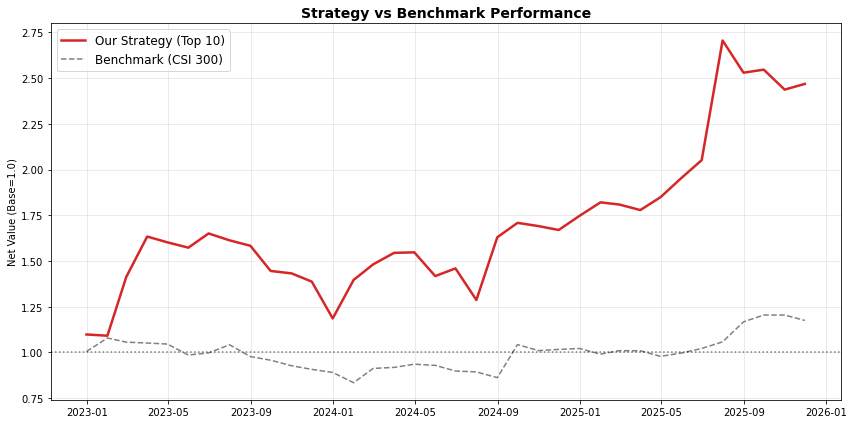

In [ ]:
def plot_strategy_vs_benchmark_robust(strategy_df, benchmark_code='000300.SH'):
    """
    通过获取日线并重采样的方式，确保基准数据与策略数据时间轴完全对齐。
    """
    print(f"正在获取基准指数日线数据并重采样 ({benchmark_code})...")
    
    # 1. 确定时间范围 (稍微放宽，确保能算出来第一个月的收益)
    start_date_str = (strategy_df.index.min() - pd.Timedelta(days=60)).strftime('%Y%m%d')
    end_date_str = (strategy_df.index.max() + pd.Timedelta(days=10)).strftime('%Y%m%d')
    
    try:
        pro = ts.pro_api()
        # 获取指数日线
        df_bench_daily = pro.index_daily(ts_code=benchmark_code, start_date=start_date_str, end_date=end_date_str, fields='trade_date,close')
    except Exception as e:
        print(f" 无法获取指数数据: {e}")
        return

    if df_bench_daily.empty:
        print(" 获取到的指数数据为空，请检查 Token 或 权限。")
        return

    # 2. 数据清洗与重采样 (完全模仿股票数据的处理逻辑)
    df_bench_daily['trade_date'] = pd.to_datetime(df_bench_daily['trade_date'])
    df_bench_daily = df_bench_daily.set_index('trade_date').sort_index()
    
    # 强制重采样为月频 (取每月最后一天收盘价)
    # 与处理股票数据时用的参数一致 ('ME' 或 'M')
    try:
        df_bench_monthly = df_bench_daily.resample('ME').last() 
    except:
        df_bench_monthly = df_bench_daily.resample('M').last()

    # 3. 计算月度收益率
    df_bench_monthly['Benchmark_Return'] = df_bench_monthly['close'].pct_change()
    
    # 4. 核心步骤：Reindex
    # 我们以策略的索引为准，强制提取对应日期的基准收益
    # 如果日期对不上（比如差1天），fillna(0) 或者使用 method='ffill' (慎用)
    # 这里我们假设 resample 逻辑一致，直接 merge
    
    comparison_df = pd.merge(
        strategy_df[['Strategy_Return']], 
        df_bench_monthly[['Benchmark_Return']], 
        left_index=True, 
        right_index=True, 
        how='inner' # 只保留两者都有的时间段
    )
    
    if comparison_df.empty:
        print(" 错误：策略日期与基准日期无法对齐。")
        print(f"策略日期样例: {strategy_df.index[:3]}")
        print(f"基准日期样例: {df_bench_monthly.index[:3]}")
        return

    # 5. 计算净值
    comparison_df['Strategy_Net_Value'] = (1 + comparison_df['Strategy_Return']).cumprod()
    comparison_df['Benchmark_Net_Value'] = (1 + comparison_df['Benchmark_Return']).cumprod()
    
    # 6. 打印最终指标
    final_strat_ret = comparison_df['Strategy_Net_Value'].iloc[-1] - 1
    final_bench_ret = comparison_df['Benchmark_Net_Value'].iloc[-1] - 1
    excess_ret = final_strat_ret - final_bench_ret
    
    print("\n" + "="*50)
    print(f"📊 {benchmark_code} 对比结果 ({len(comparison_df)} 个月)")
    print("="*50)
    print(f"策略累计收益: {final_strat_ret:.2%}")
    print(f"基准累计收益: {final_bench_ret:.2%}")
    print(f"超额收益 (Alpha): {excess_ret:.2%}")
    print("="*50)

    # 7. 绘图
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df.index, comparison_df['Strategy_Net_Value'], 
             label='Our Strategy (Top 10)', color='#d62728', linewidth=2.5)
    plt.plot(comparison_df.index, comparison_df['Benchmark_Net_Value'], 
             label='Benchmark (CSI 300)', color='gray', linestyle='--', linewidth=1.5)
    
    plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5)
    plt.title('Strategy vs Benchmark Performance', fontsize=14, fontweight='bold')
    plt.ylabel('Net Value (Base=1.0)')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 运行修正后的函数
if __name__ == "__main__":
    plot_strategy_vs_benchmark_robust(optimized_returns, benchmark_code='000300.SH')

 正在全量数据上训练模型以提取特征重要性...

 Top 10 最重要特征 (基于 Gain/贡献度)
      Feature  Importance
0       ROC20    0.139665
1  Variance20    0.081226
2       ATR14    0.068345
3          EP    0.065893
4        size    0.056657
5      TRIX10    0.054492
6    Volume1M    0.049311
7     Price1M    0.047759
8      PLRC12    0.047257
9       RSI14    0.044251


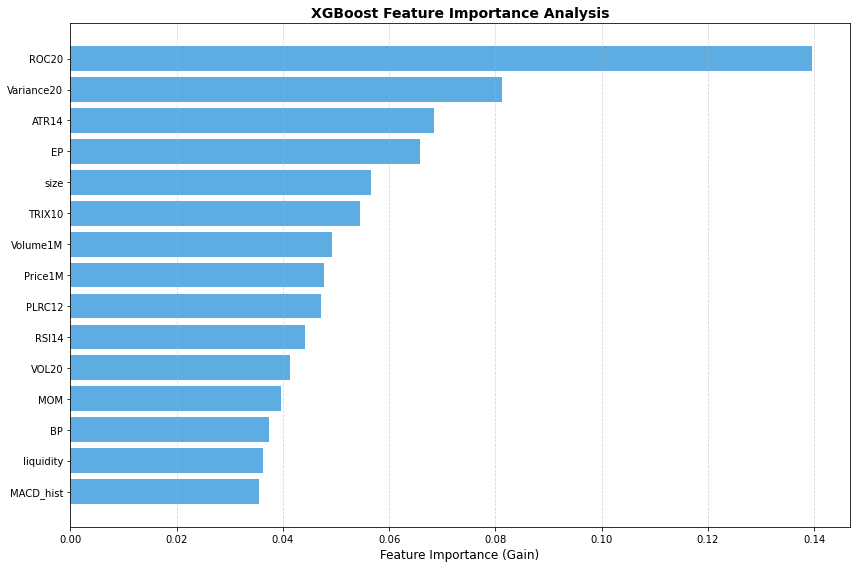

In [ ]:
# 特征重要性
def plot_feature_importance_analysis(full_df_processed, feature_cols, target_col='next_mth_return'):
    print(" 正在全量数据上训练模型以提取特征重要性...")
    
    # 1. 准备数据 (使用全部可用数据)
    # 移除缺失值
    clean_df = full_df_processed.dropna(subset=feature_cols + [target_col])
    
    X = clean_df[feature_cols].values
    y = clean_df[target_col].values
    
    # 2. 训练模型 (使用与回测相同的参数)
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(X, y)
    
    # 3. 提取重要性
    # get_booster().get_score(importance_type='gain') 通常比默认的 weight 更准确
    importance_dict = model.get_booster().get_score(importance_type='gain')
    
    # 映射回特征名    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1] # 降序排列
    
    # 创建 DataFrame
    feat_imp_df = pd.DataFrame({
        'Feature': [feature_cols[i] for i in indices],
        'Importance': importances[indices]
    })
    
    print("\n" + "="*50)
    print(" Top 10 最重要特征 (基于 Gain/贡献度)")
    print("="*50)
    print(feat_imp_df.head(10))
    print("="*50)
    
    # 4. 绘图
    plt.figure(figsize=(12, 8))
    
    # 为了美观，倒序画图，让最大的在上面
    top_features = feat_imp_df.head(15).sort_values('Importance', ascending=True)
    
    plt.barh(top_features['Feature'], top_features['Importance'], color='#3498db', alpha=0.8)
    plt.xlabel('Feature Importance (Gain)', fontsize=12)
    plt.title('XGBoost Feature Importance Analysis', fontsize=14, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ============================================================
# 执行绘图
# ============================================================
if __name__ == "__main__":
    plot_feature_importance_analysis(full_df_processed, feature_cols)